# Generator Checkpoint Analysis

This notebook helps you explore and analyze generator checkpoints saved during training.

## Features:
- Load and inspect checkpoint metadata
- Visualize generator architecture
- Compare checkpoints across rounds
- Analyze training statistics

In [3]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
from collections import defaultdict
import json

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 1. Configuration

In [11]:
# Configure checkpoint directory
CHECKPOINT_DIR = "/home/lpala/fedgfe/checkpoints"

# You can also specify a specific checkpoint file
# CHECKPOINT_FILE = "checkpoints/generators/client_generator_node0.pt"

print(f"Checkpoint directory: {CHECKPOINT_DIR}")
print(f"Directory exists: {Path(CHECKPOINT_DIR).exists()}")

Checkpoint directory: /home/lpala/fedgfe/checkpoints
Directory exists: True


## 2. Find All Checkpoints

In [12]:
def find_checkpoints(checkpoint_dir):
    """Find all checkpoint files in the directory."""
    checkpoint_files = glob.glob(f"{checkpoint_dir}/**/*.pt", recursive=True)
    return sorted(checkpoint_files)

checkpoints = find_checkpoints(CHECKPOINT_DIR)

print(f"Found {len(checkpoints)} checkpoint(s):\n")
for i, ckpt in enumerate(checkpoints, 1):
    print(f"{i}. {ckpt}")

Found 9 checkpoint(s):

1. /home/lpala/fedgfe/checkpoints/generators/vae_perclass_node0_class_dog_round_1.pt
2. /home/lpala/fedgfe/checkpoints/vae_1n_c/vae_perclass_node0_class_dog_round_10.pt
3. /home/lpala/fedgfe/checkpoints/vae_1n_c/vae_perclass_node0_class_dog_round_15.pt
4. /home/lpala/fedgfe/checkpoints/vae_1n_c/vae_perclass_node0_class_dog_round_20.pt
5. /home/lpala/fedgfe/checkpoints/vae_1n_c/vae_perclass_node0_class_dog_round_25.pt
6. /home/lpala/fedgfe/checkpoints/vae_1n_c/vae_perclass_node0_class_dog_round_30.pt
7. /home/lpala/fedgfe/checkpoints/vae_1n_c/vae_perclass_node0_class_dog_round_35.pt
8. /home/lpala/fedgfe/checkpoints/vae_1n_c/vae_perclass_node0_class_dog_round_40.pt
9. /home/lpala/fedgfe/checkpoints/vae_1n_c/vae_perclass_node0_class_dog_round_5.pt


## 3. Load and Inspect Checkpoint Metadata

In [9]:
def load_checkpoint_metadata(checkpoint_path):
    """Load checkpoint and extract metadata."""
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    
    metadata = {}
    
    # Extract metadata fields
    metadata_fields = [
        'client_id', 'node_id', 'round', 'generator_type', 'generator_granularity',
        'generator_key', 'diffusion_type', 'visual_dim', 'input_dim', 'hidden_dim',
        'latent_dim', 'sequence_length', 'dataset_name', 'selected_classes',
        'generator_classes', 'training_samples', 'training_epochs',
        'final_loss', 'timestamp', 'device'
    ]
    
    for field in metadata_fields:
        metadata[field] = checkpoint.get(field, None)
    
    # Check for state dicts
    metadata['has_generator_state'] = 'generator_state_dict' in checkpoint
    metadata['has_optimizer_state'] = 'optimizer_state_dict' in checkpoint
    
    # Get state dict info if available
    if metadata['has_generator_state']:
        state_dict = checkpoint['generator_state_dict']
        metadata['num_parameters'] = sum(p.numel() for p in state_dict.values())
        metadata['parameter_keys'] = list(state_dict.keys())
    
    return checkpoint, metadata

# Load first checkpoint as example
if checkpoints:
    checkpoint_path = checkpoints[0]
    print(f"Loading: {checkpoint_path}\n")
    
    checkpoint, metadata = load_checkpoint_metadata(checkpoint_path)
    
    print("=" * 80)
    print("CHECKPOINT METADATA")
    print("=" * 80)
    
    for key, value in metadata.items():
        if key != 'parameter_keys':  # Skip long list
            print(f"{key:25s}: {value}")
    
    print("\n" + "=" * 80)

Loading: /home/lpala/fedgfe/checkpoints/generators/vae_perclass_node0_class_dog_round_1.pt

CHECKPOINT METADATA
client_id                : 0
node_id                  : 0
round                    : 1
generator_type           : vae
generator_granularity    : per_class
generator_key            : dog
diffusion_type           : flux
visual_dim               : None
input_dim                : None
hidden_dim               : None
latent_dim               : None
sequence_length          : None
dataset_name             : ESC50
selected_classes         : ['dog']
generator_classes        : ['dog']
training_samples         : None
training_epochs          : None
final_loss               : None
timestamp                : 2025-12-20T05:13:40.745019
device                   : None
has_generator_state      : True
has_optimizer_state      : True
num_parameters           : 1913277440



## 4. Analyze All Checkpoints

In [ ]:
def analyze_all_checkpoints(checkpoint_files):
    """Analyze all checkpoints and create a summary dataframe."""
    records = []
    
    for ckpt_file in checkpoint_files:
        try:
            _, metadata = load_checkpoint_metadata(ckpt_file)
            metadata['checkpoint_file'] = Path(ckpt_file).name
            records.append(metadata)
        except Exception as e:
            print(f"Error loading {ckpt_file}: {e}")
    
    df = pd.DataFrame(records)
    return df

if checkpoints:
    df_checkpoints = analyze_all_checkpoints(checkpoints)
    
    print("\nCheckpoint Summary:")
    print("=" * 80)
    
    # Select key columns to display
    display_cols = ['checkpoint_file', 'node_id', 'round', 'generator_type', 
                    'generator_granularity', 'generator_key', 'final_loss', 
                    'training_samples', 'num_parameters']
    
    available_cols = [col for col in display_cols if col in df_checkpoints.columns]
    
    display(df_checkpoints[available_cols])
else:
    print("No checkpoints found to analyze.")

## 5. Visualize Generator Architecture

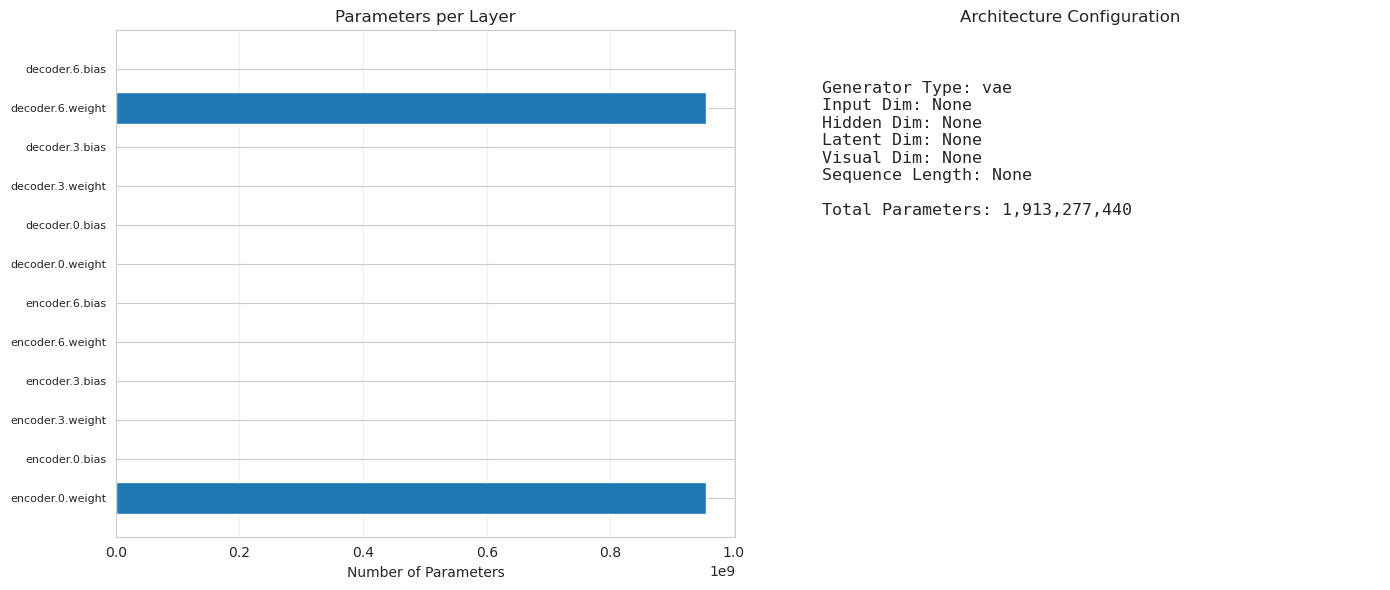


Total parameters: 1,913,277,440


In [10]:
def visualize_generator_architecture(checkpoint_path):
    """Visualize the generator architecture from checkpoint."""
    checkpoint, metadata = load_checkpoint_metadata(checkpoint_path)
    
    if not metadata['has_generator_state']:
        print("No generator state found in checkpoint")
        return
    
    state_dict = checkpoint['generator_state_dict']
    
    # Extract layer information
    layers = []
    layer_sizes = []
    
    for key, param in state_dict.items():
        if 'weight' in key:
            layers.append(key)
            layer_sizes.append(param.shape)
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: Parameter count per layer
    param_counts = [param.numel() for param in state_dict.values()]
    param_names = list(state_dict.keys())
    
    ax1.barh(range(len(param_names)), param_counts)
    ax1.set_yticks(range(len(param_names)))
    ax1.set_yticklabels(param_names, fontsize=8)
    ax1.set_xlabel('Number of Parameters')
    ax1.set_title('Parameters per Layer')
    ax1.grid(axis='x', alpha=0.3)
    
    # Plot 2: Architecture summary
    architecture_info = [
        f"Generator Type: {metadata.get('generator_type', 'N/A')}",
        f"Input Dim: {metadata.get('input_dim', 'N/A')}",
        f"Hidden Dim: {metadata.get('hidden_dim', 'N/A')}",
        f"Latent Dim: {metadata.get('latent_dim', 'N/A')}",
        f"Visual Dim: {metadata.get('visual_dim', 'N/A')}",
        f"Sequence Length: {metadata.get('sequence_length', 'N/A')}",
        f"\nTotal Parameters: {metadata.get('num_parameters', 'N/A'):,}",
    ]
    
    ax2.axis('off')
    ax2.text(0.1, 0.9, '\n'.join(architecture_info), 
             fontsize=12, verticalalignment='top',
             fontfamily='monospace')
    ax2.set_title('Architecture Configuration')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nTotal parameters: {metadata.get('num_parameters', 'N/A'):,}")

if checkpoints:
    visualize_generator_architecture(checkpoints[0])

## 6. Compare Checkpoints Across Rounds

In [13]:
def plot_training_progress(df_checkpoints):
    """Plot training progress across rounds."""
    if 'round' not in df_checkpoints.columns or 'final_loss' not in df_checkpoints.columns:
        print("Missing 'round' or 'final_loss' information in checkpoints")
        return
    
    # Filter out None values
    df_plot = df_checkpoints[df_checkpoints['round'].notna() & df_checkpoints['final_loss'].notna()].copy()
    
    if df_plot.empty:
        print("No valid data to plot")
        return
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Loss over rounds
    if 'node_id' in df_plot.columns:
        for node_id in df_plot['node_id'].unique():
            node_data = df_plot[df_plot['node_id'] == node_id].sort_values('round')
            axes[0].plot(node_data['round'], node_data['final_loss'], 
                        marker='o', label=f'Node {node_id}')
    else:
        df_plot_sorted = df_plot.sort_values('round')
        axes[0].plot(df_plot_sorted['round'], df_plot_sorted['final_loss'], 
                    marker='o', label='Generator')
    
    axes[0].set_xlabel('Round')
    axes[0].set_ylabel('Final Loss')
    axes[0].set_title('Training Loss Over Rounds')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Plot 2: Loss distribution by round
    if len(df_plot) > 1:
        df_plot.boxplot(column='final_loss', by='round', ax=axes[1])
        axes[1].set_xlabel('Round')
        axes[1].set_ylabel('Final Loss')
        axes[1].set_title('Loss Distribution by Round')
        plt.suptitle('')  # Remove automatic title
    else:
        axes[1].text(0.5, 0.5, 'Not enough data\nfor distribution plot', 
                    ha='center', va='center', fontsize=12)
        axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

if checkpoints and 'df_checkpoints' in locals():
    plot_training_progress(df_checkpoints)

## 7. Load Generator Model from Checkpoint

In [ ]:
# Add system path to import generator classes
import sys
sys.path.append('/home/lpala/fedgfe/system')

from flcore.trainmodel.generators import ConditionedVAEGenerator, VAELoss

def load_generator_model(checkpoint_path):
    """Load generator model from checkpoint."""
    checkpoint, metadata = load_checkpoint_metadata(checkpoint_path)
    
    if not metadata['has_generator_state']:
        print("No generator state found in checkpoint")
        return None
    
    # Create generator with same configuration
    generator = ConditionedVAEGenerator(
        input_dim=metadata.get('input_dim', 768),
        hidden_dim=metadata.get('hidden_dim', 1024),
        latent_dim=metadata.get('latent_dim', 256),
        visual_dim=metadata.get('visual_dim', 4864),
        sequence_length=metadata.get('sequence_length', 4)
    )
    
    # Load weights
    generator.load_state_dict(checkpoint['generator_state_dict'])
    generator.eval()
    
    print(f"✓ Generator loaded from {Path(checkpoint_path).name}")
    print(f"  - Type: {metadata.get('generator_type', 'N/A')}")
    print(f"  - Parameters: {metadata.get('num_parameters', 'N/A'):,}")
    print(f"  - Training samples: {metadata.get('training_samples', 'N/A')}")
    print(f"  - Final loss: {metadata.get('final_loss', 'N/A')}")
    
    return generator, metadata

if checkpoints:
    generator, gen_metadata = load_generator_model(checkpoints[0])

## 8. Export Checkpoint Summary to CSV

In [ ]:
if 'df_checkpoints' in locals() and not df_checkpoints.empty:
    output_file = f"{CHECKPOINT_DIR}/checkpoint_summary.csv"
    
    # Select columns to export (exclude complex objects)
    export_cols = [col for col in df_checkpoints.columns 
                   if col not in ['parameter_keys', 'selected_classes', 'generator_classes']]
    
    df_checkpoints[export_cols].to_csv(output_file, index=False)
    print(f"✓ Checkpoint summary exported to: {output_file}")
else:
    print("No checkpoint data to export")

## 9. Detailed Checkpoint Inspector

In [14]:
def inspect_checkpoint_detailed(checkpoint_path):
    """Detailed inspection of a specific checkpoint."""
    checkpoint, metadata = load_checkpoint_metadata(checkpoint_path)
    
    print("\n" + "=" * 80)
    print(f"DETAILED CHECKPOINT INSPECTION: {Path(checkpoint_path).name}")
    print("=" * 80)
    
    # Section 1: Node Information
    print("\n[1] NODE INFORMATION")
    print("-" * 80)
    print(f"Node ID:          {metadata.get('node_id', 'N/A')}")
    print(f"Round:            {metadata.get('round', 'N/A')}")
    print(f"Dataset:          {metadata.get('dataset_name', 'N/A')}")
    print(f"Timestamp:        {metadata.get('timestamp', 'N/A')}")
    print(f"Device:           {metadata.get('device', 'N/A')}")
    
    # Section 2: Generator Configuration
    print("\n[2] GENERATOR CONFIGURATION")
    print("-" * 80)
    print(f"Type:             {metadata.get('generator_type', 'N/A')}")
    print(f"Granularity:      {metadata.get('generator_granularity', 'N/A')}")
    print(f"Generator Key:    {metadata.get('generator_key', 'N/A')}")
    print(f"Diffusion Type:   {metadata.get('diffusion_type', 'N/A')}")
    
    # Section 3: Architecture
    print("\n[3] ARCHITECTURE")
    print("-" * 80)
    print(f"Input Dim:        {metadata.get('input_dim', 'N/A')}")
    print(f"Hidden Dim:       {metadata.get('hidden_dim', 'N/A')}")
    print(f"Latent Dim:       {metadata.get('latent_dim', 'N/A')}")
    print(f"Visual Dim:       {metadata.get('visual_dim', 'N/A')}")
    print(f"Sequence Length:  {metadata.get('sequence_length', 'N/A')}")
    print(f"Total Parameters: {metadata.get('num_parameters', 'N/A'):,}")
    
    # Section 4: Training Information
    print("\n[4] TRAINING INFORMATION")
    print("-" * 80)
    print(f"Training Samples: {metadata.get('training_samples', 'N/A')}")
    print(f"Training Epochs:  {metadata.get('training_epochs', 'N/A')}")
    print(f"Final Loss:       {metadata.get('final_loss', 'N/A')}")
    
    # Section 5: Classes
    print("\n[5] CLASSES")
    print("-" * 80)
    selected_classes = metadata.get('selected_classes', None)
    if selected_classes:
        print(f"Selected Classes: {', '.join(map(str, selected_classes))}")
    else:
        print("Selected Classes: N/A")
    
    generator_classes = metadata.get('generator_classes', None)
    if generator_classes:
        print(f"Generator Classes: {', '.join(map(str, generator_classes))}")
    else:
        print("Generator Classes: N/A")
    
    # Section 6: State Dicts
    print("\n[6] STATE DICTIONARIES")
    print("-" * 80)
    print(f"Has Generator State:  {metadata.get('has_generator_state', False)}")
    print(f"Has Optimizer State:  {metadata.get('has_optimizer_state', False)}")
    
    if metadata.get('has_generator_state'):
        print(f"\nGenerator Layers ({len(metadata.get('parameter_keys', []))})")
        for i, key in enumerate(metadata.get('parameter_keys', [])[:10], 1):
            print(f"  {i}. {key}")
        if len(metadata.get('parameter_keys', [])) > 10:
            print(f"  ... and {len(metadata.get('parameter_keys', [])) - 10} more")
    
    print("\n" + "=" * 80 + "\n")

# Inspect the first checkpoint
if checkpoints:
    inspect_checkpoint_detailed(checkpoints[0])


DETAILED CHECKPOINT INSPECTION: vae_perclass_node0_class_dog_round_1.pt

[1] NODE INFORMATION
--------------------------------------------------------------------------------
Node ID:          0
Round:            1
Dataset:          ESC50
Timestamp:        2025-12-20T05:13:40.745019
Device:           None

[2] GENERATOR CONFIGURATION
--------------------------------------------------------------------------------
Type:             vae
Granularity:      per_class
Generator Key:    dog
Diffusion Type:   flux

[3] ARCHITECTURE
--------------------------------------------------------------------------------
Input Dim:        None
Hidden Dim:       None
Latent Dim:       None
Visual Dim:       None
Sequence Length:  None
Total Parameters: 1,913,277,440

[4] TRAINING INFORMATION
--------------------------------------------------------------------------------
Training Samples: None
Training Epochs:  None
Final Loss:       None

[5] CLASSES
----------------------------------------------------

## 10. Custom Analysis

Use this section for your own custom analysis.

In [ ]:
# Your custom analysis here
# Example: Compare two specific checkpoints

if len(checkpoints) >= 2:
    print("Comparing first two checkpoints...\n")
    
    for i, ckpt_path in enumerate(checkpoints[:2], 1):
        _, meta = load_checkpoint_metadata(ckpt_path)
        print(f"Checkpoint {i}: {Path(ckpt_path).name}")
        print(f"  Round: {meta.get('round', 'N/A')}")
        print(f"  Loss: {meta.get('final_loss', 'N/A')}")
        print(f"  Samples: {meta.get('training_samples', 'N/A')}")
        print()

In [ ]:
# Common checkpoint directories to scan
common_dirs = [
    "/home/lpala/fedgfe/checkpoints/generators",
    "/home/lpala/fedgfe/checkpoints/generators/vae_1n_50c",
    "/home/lpala/fedgfe/checkpoints/generators/vae_1n_1c",
    "/home/lpala/fedgfe/checkpoints/vae_1n_c",
]

print("Scanning common checkpoint directories...")
print("=" * 100)
print()

all_checkpoints = []
for directory in common_dirs:
    dir_path = Path(directory)
    if dir_path.exists():
        ckpts = list(dir_path.glob("*.pt"))
        print(f"📁 {directory}")
        print(f"   Found {len(ckpts)} checkpoint(s)")
        all_checkpoints.extend([str(p) for p in ckpts])
    else:
        print(f"❌ {directory} (does not exist)")
    print()

print("=" * 100)
print(f"\nTotal checkpoints found across all directories: {len(all_checkpoints)}")
print()

if all_checkpoints:
    print("Running sequence_length check on all found checkpoints...")
    print()
    df_all_seq_len = check_sequence_length_in_checkpoints(all_checkpoints)
else:
    print("No checkpoints found in any directory.")

## 12. Scan Multiple Checkpoint Directories

Scan common checkpoint directories to find all generator checkpoints.

In [ ]:
def check_sequence_length_in_checkpoints(checkpoint_files):
    """Check sequence_length field in all checkpoints."""
    print("=" * 100)
    print("SEQUENCE_LENGTH CHECK IN ALL CHECKPOINTS")
    print("=" * 100)
    print()
    
    results = []
    
    for ckpt_path in checkpoint_files:
        try:
            checkpoint = torch.load(ckpt_path, map_location='cpu')
            
            filename = Path(ckpt_path).name
            has_seq_len = 'sequence_length' in checkpoint
            seq_len_value = checkpoint.get('sequence_length', None)
            
            # Also check for other critical fields
            has_visual_dim = 'visual_dim' in checkpoint
            visual_dim_value = checkpoint.get('visual_dim', None)
            has_use_conditioned = 'use_conditioned_vae' in checkpoint
            use_conditioned_value = checkpoint.get('use_conditioned_vae', None)
            
            result = {
                'file': filename,
                'sequence_length_present': has_seq_len,
                'sequence_length_value': seq_len_value,
                'visual_dim_present': has_visual_dim,
                'visual_dim_value': visual_dim_value,
                'use_conditioned_vae_present': has_use_conditioned,
                'use_conditioned_vae_value': use_conditioned_value,
            }
            results.append(result)
            
        except Exception as e:
            print(f"❌ Error loading {Path(ckpt_path).name}: {e}")
            results.append({
                'file': Path(ckpt_path).name,
                'error': str(e)
            })
    
    # Create summary dataframe
    df_results = pd.DataFrame(results)
    
    # Display results
    print(f"Total checkpoints analyzed: {len(checkpoint_files)}")
    print()
    
    if 'sequence_length_present' in df_results.columns:
        num_with_seq_len = df_results['sequence_length_present'].sum()
        num_without_seq_len = (~df_results['sequence_length_present']).sum()
        
        print(f"✓ Checkpoints WITH sequence_length:    {num_with_seq_len}")
        print(f"✗ Checkpoints WITHOUT sequence_length: {num_without_seq_len}")
        print()
        
        if num_with_seq_len > 0:
            print("Sequence length values found:")
            seq_len_values = df_results[df_results['sequence_length_present']]['sequence_length_value'].value_counts()
            for value, count in seq_len_values.items():
                print(f"  - {value}: {count} checkpoint(s)")
        print()
        
        # Visual dim summary
        num_with_visual_dim = df_results['visual_dim_present'].sum()
        print(f"✓ Checkpoints WITH visual_dim:    {num_with_visual_dim}")
        print(f"✗ Checkpoints WITHOUT visual_dim: {len(checkpoint_files) - num_with_visual_dim}")
        
        if num_with_visual_dim > 0:
            print("\nVisual dim values found:")
            visual_dim_values = df_results[df_results['visual_dim_present']]['visual_dim_value'].value_counts()
            for value, count in visual_dim_values.items():
                print(f"  - {value}: {count} checkpoint(s)")
        print()
        
        # use_conditioned_vae summary
        num_with_conditioned = df_results['use_conditioned_vae_present'].sum()
        print(f"✓ Checkpoints WITH use_conditioned_vae:    {num_with_conditioned}")
        print(f"✗ Checkpoints WITHOUT use_conditioned_vae: {len(checkpoint_files) - num_with_conditioned}")
    
    print()
    print("=" * 100)
    print()
    
    # Display detailed table
    print("Detailed breakdown:")
    display(df_results)
    
    return df_results

if checkpoints:
    df_seq_len_check = check_sequence_length_in_checkpoints(checkpoints)
else:
    print("No checkpoints found to analyze.")

## 11. Check sequence_length in All Checkpoints

This section checks if `sequence_length` is present in all checkpoints and shows its values.